# Example with Korg-based grid interpolator

In [1]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_rotation, evaluate_rotation
from spice.spectrum import simulate_observed_flux
import matplotlib.pyplot as plt
%matplotlib inline

from spice.spectrum.spectrum_korg import KorgSpectrumEmulator
import jax.numpy as jnp

/Users/mjablons/anaconda3/envs/astro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's define a ```KorgSpectrumEmulator``` as with other types of spectra models. This emulator is based on a ```RegularGridInterpolator``` and interpolates between the corresponding ranges of parameters:

**Note**: The ```KorgSpectrumEmulator``` is downloaded from huggingface to a selected cache location. It's around 10 GBs, so if you want to change the location of the HuggingFace cache, make sure to set the environment variable:

```bash
export HF_HOME=/your/cache/location
```

A small grid (~300 MB) will be downloaded by default. To switch to a larger grid (~10 GB), pass the argument of ```grid_type='regular'```.

In [2]:
k = KorgSpectrumEmulator()

Using default cache path: ~/.spice_cache
Attempting to download and load model from Hugging Face Hub...
Model downloaded to: /Users/mjablons/.cache/huggingface/hub/models--mjablonska--spice_korg_interpolator/snapshots/5300175a44c55b505c9b93849ca3b935c8d4a734/small_grid.h5
Loading model parameters...
Parameters shape: (1200, 4)
Loading model intensities...
Intensities shape: (1200, 65992)
Loading wavelengths...
Wavelengths shape: (65992,)
Loading continuum intensities...
Continuum intensities shape: (1200, 6599)
Loading continuum wavelengths...
Continuum wavelengths shape: (6599,)
Model loaded successfully


**Note**: the first execution of ```intensity``` will most probably take some time. After it's compiled with ```jax.jit```, it will be much faster.

In [3]:
wavelengths = jnp.linspace(5600, 6000, 1000)
intensities = k.intensity(jnp.log10(wavelengths), 0.5, jnp.array([5777, 4.44, 0.0]))

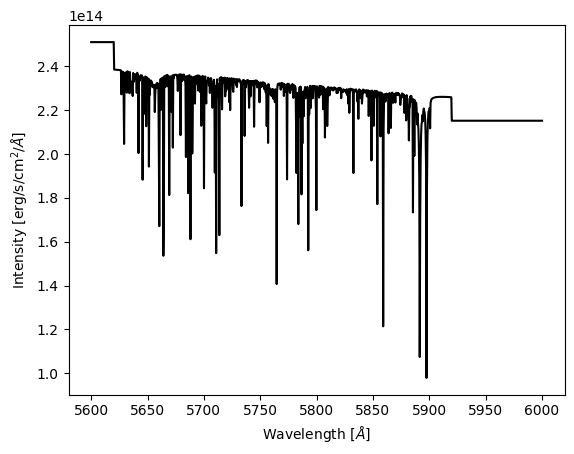

In [6]:
plt.plot(wavelengths, intensities[:, 0]*intensities[:, 1], color='black')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Intensity [erg/s/cm$^2$/$\AA$]')
plt.show()


# An example with a Mesh Model

Let's create a mesh model of a star and simulate its spectrum. We'll use an icosphere model with 1000 vertices (just to make it fast), radius 1 $R_\odot$, mass 1 $M_\odot$, and base temperature of 5700 K. We'll simulate both a non-rotating and rotating star to see the effect of rotation on the spectrum.

First, we'll simulate a non-rotating star's spectrum in the wavelength range 5650-5925 Å. Then we'll add rotation at 10 km/s and compare the spectra.


In [27]:

base_temp = 5700
wavelengths = jnp.linspace(5650, 5910, 10000)
m = IcosphereModel.construct(1000, 1., 1., k.to_parameters(dict(teff=base_temp)), k.stellar_parameter_names)
non_rotated_spec = simulate_observed_flux(k.intensity, m, jnp.log10(wavelengths))

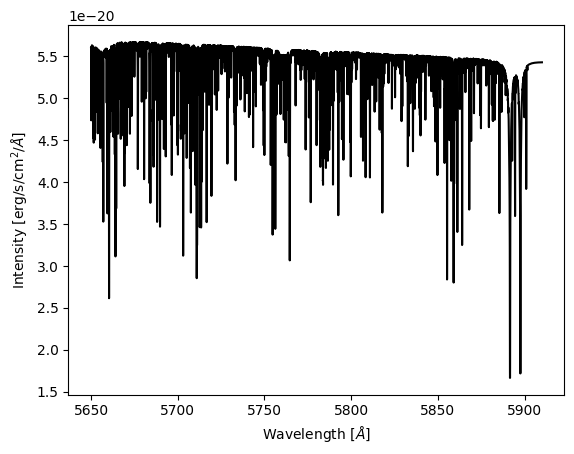

In [28]:
plt.plot(wavelengths, non_rotated_spec[:, 0]*non_rotated_spec[:, 1], color='black');
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Intensity [erg/s/cm$^2$/$\AA$]')
plt.show()

Let's add a rotation of 10 km/s (at the equator) and compare the spectra.

The evaluate_rotation() function takes a mesh model with rotation velocity information and an inclination angle, and returns a new mesh model with updated vertex positions and velocities based on rigid body rotation.

It follows functional programming principles by:
1. Taking immutable inputs (mesh model and angle)
2. Not modifying the input model
3. Returning a new model with the rotational transformations applied
4. Having no side effects

In [29]:
m_r = add_rotation(m, rotation_velocity=10.)
m_rotated = evaluate_rotation(m_r, 0.)
rotated_spec = simulate_observed_flux(k.intensity, m_rotated, jnp.log10(wavelengths))

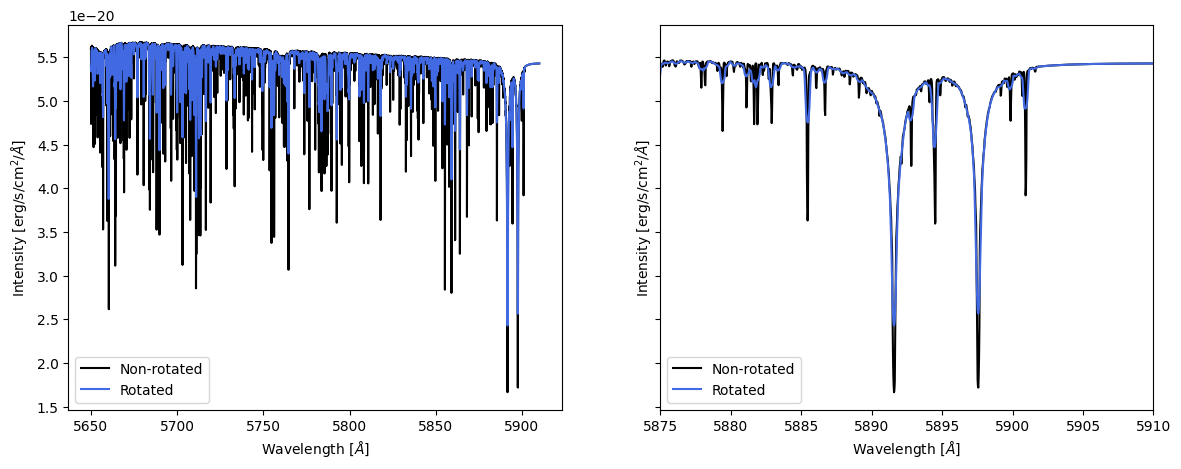

In [30]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

ax1.plot(wavelengths, non_rotated_spec[:, 0]*non_rotated_spec[:, 1], color='black', label='Non-rotated')
ax1.plot(wavelengths, rotated_spec[:, 0]*rotated_spec[:, 1], color='royalblue', label='Rotated')
ax1.set_xlabel(r'Wavelength [$\AA$]')
ax1.set_ylabel(r'Intensity [erg/s/cm$^2$/$\AA$]')
ax1.legend()

ax2.plot(wavelengths, non_rotated_spec[:, 0]*non_rotated_spec[:, 1], color='black', label='Non-rotated')
ax2.plot(wavelengths, rotated_spec[:, 0]*rotated_spec[:, 1], color='royalblue', label='Rotated')
ax2.set_xlabel(r'Wavelength [$\AA$]')
ax2.set_ylabel(r'Intensity [erg/s/cm$^2$/$\AA$]')
ax2.set_xlim(5875, 5910)
ax2.legend()

plt.show()
